In [1]:
import sys
import os

current_dir = os.getcwd()
print(current_dir)  

sys.path.append('/kaggle/input/instance')


from instancenormalization import InstanceNormalization


/kaggle/working


In [2]:

from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate

#from instancenormalization import InstanceNormalization  

from matplotlib import pyplot


def define_discriminator(image_shape):

    init = RandomNormal(stddev=0.02)

    in_image = Input(shape=image_shape)

    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    d = LeakyReLU(alpha=0.2)(d)

    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)

    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)

    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)

    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)

    patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)

    model = Model(in_image, patch_out)

    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss_weights=0.5)
    return model

def resnet_block(n_filters, input_layer):

    init = RandomNormal(stddev=0.02)

    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)

    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)

    g = Concatenate()([g, input_layer])
    return g



def define_generator(image_shape, n_resnet=9):

    init = RandomNormal(stddev=0.02)

    in_image = Input(shape=image_shape)

    g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)

    g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)

    g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)

    for _ in range(n_resnet):
        g = resnet_block(256, g)

    g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)

    g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)

    g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    out_image = Activation('tanh')(g)

    model = Model(in_image, out_image)
    return model


def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
 
    g_model_1.trainable = True

    d_model.trainable = False
    g_model_2.trainable = False


    input_gen = Input(shape=image_shape)
    gen1_out = g_model_1(input_gen)
    output_d = d_model(gen1_out)

    input_id = Input(shape=image_shape)
    output_id = g_model_1(input_id)

    output_f = g_model_2(gen1_out)

    gen2_out = g_model_2(input_id)
    output_b = g_model_1(gen2_out)


    model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])

    opt = Adam(learning_rate=0.0002, beta_1=0.5)

    model.compile(loss=['mse', 'mae', 'mae', 'mae'], 
               loss_weights=[1, 5, 10, 10], optimizer=opt)
    return model


def load_real_samples(filename):

    data = load(filename)

    X1, X2 = data['arr_0'], data['arr_1']

    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]


def generate_real_samples(dataset, n_samples, patch_shape):

    ix = randint(0, dataset.shape[0], n_samples)

    X = dataset[ix]

    y = ones((n_samples, patch_shape, patch_shape, 1))
    return X, y


def generate_fake_samples(g_model, dataset, patch_shape):

    X = g_model.predict(dataset)

    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y


def save_models(step, g_model_AtoB, g_model_BtoA):

    filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
    g_model_AtoB.save(filename1)

    filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
    g_model_BtoA.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

def summarize_performance(step, g_model, trainX, name, n_samples=5):

    X_in, _ = generate_real_samples(trainX, n_samples, 0)

    X_out, _ = generate_fake_samples(g_model, X_in, 0)

    X_in = (X_in + 1) / 2.0
    X_out = (X_out + 1) / 2.0

    for i in range(n_samples):
        pyplot.subplot(2, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X_in[i])

    for i in range(n_samples):
        pyplot.subplot(2, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_out[i])

    filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
    pyplot.savefig(filename1)
    pyplot.close()



def update_image_pool(pool, images, max_size=50):
    selected = list()
    for image in images:
        if len(pool) < max_size:

            pool.append(image)
            selected.append(image)
        elif random() < 0.5:

            selected.append(image)
        else:

            ix = randint(0, len(pool))
            selected.append(pool[ix])
            pool[ix] = image
    return asarray(selected)


def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=1):

    n_epochs, n_batch, = epochs, 1 

    n_patch = d_model_A.output_shape[1]

    trainA, trainB = dataset

    poolA, poolB = list(), list()

    bat_per_epo = int(len(trainA) / n_batch)

    n_steps = bat_per_epo * n_epochs


    for i in range(n_steps):

        X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
        X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)

        X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
        X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
        X_fakeA = update_image_pool(poolA, X_fakeA)
        X_fakeB = update_image_pool(poolB, X_fakeB)


        g_loss2, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])

        dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
        dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)

        g_loss1, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])

        dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
        dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)

        print('Iteration>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))


        if (i+1) % (bat_per_epo * 1) == 0:

            summarize_performance(i, g_model_AtoB, trainA, 'AtoB')

            summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
        if (i+1) % (bat_per_epo * 5) == 0:
            save_models(i, g_model_AtoB, g_model_BtoA)



In [3]:
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from matplotlib import pyplot as plt
import numpy as np

In [4]:



def load_images(path, size=(256,256)):
    data_list = list()

    for filename in listdir(path):

        pixels = load_img(path + filename, target_size=size)

        pixels = img_to_array(pixels)

        data_list.append(pixels)
    return asarray(data_list)



path = '/kaggle/input/night2daytiming/NightTraffic2DayTraffic/'


dataA_all = load_images(path + 'trainA/')
print('Loaded dataA: ', dataA_all.shape)

Loaded dataA:  (1029, 256, 256, 3)


In [29]:
type(dataA_all)

numpy.ndarray

In [10]:
from sklearn.utils import resample
dataA = resample(dataA_all, 
                 replace=False,     
                 n_samples=45,    
                 random_state=42) 

dataB_all = load_images(path + 'trainB/')
print('Loaded dataB: ', dataB_all.shape) 
dataB = resample(dataB_all, 
                 replace=False,     
                 n_samples=45,    
                 random_state=42) 



Loaded dataB:  (1060, 256, 256, 3)


In [5]:
dataA=dataA_all[700:745]
dataB_all = load_images(path + 'trainB/')
dataB=dataB_all[700:745]

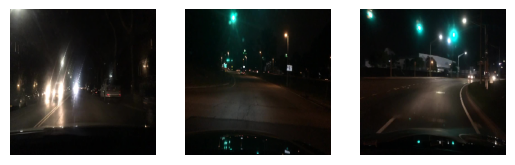

In [11]:

n_samples = 3
for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow(dataA[i].astype('uint8'))

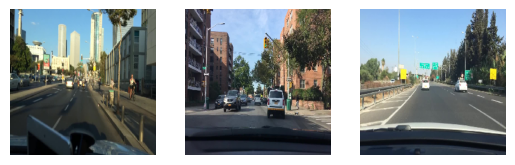

In [12]:

for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + n_samples + i)
    plt.axis('off')
    plt.imshow(dataB[i].astype('uint8'))
plt.show()

In [6]:

data = [dataA, dataB]

print('Loaded', data[0].shape, data[1].shape)


def preprocess_data(data):

    X1, X2 = data[0], data[1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

dataset = preprocess_data(data)

Loaded (45, 256, 256, 3) (45, 256, 256, 3)


In [7]:
len(dataset)

2

In [10]:
image_shape = dataset[0].shape[:]

In [16]:
image_shape

(45, 256, 256, 3)

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [18]:

image_shape = dataset[0].shape[1:]

g_model_AtoB = define_generator(image_shape)

g_model_BtoA = define_generator(image_shape)

d_model_A = define_discriminator(image_shape)

d_model_B = define_discriminator(image_shape)

c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)

c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

In [19]:
sdf,fgh=dataset
len(sdf)

45

In [18]:
from datetime import datetime 
start1 = datetime.now() 

train(d_model_A, d_model_B, model_AtoB, model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=2)

stop1 = datetime.now()
execution_time = stop1-start1
print("Execution time is: ", execution_time)



I0000 00:00:1725728915.165675     139 service.cc:145] XLA service 0x783bcc0033b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725728915.165740     139 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


I0000 00:00:1725728920.204198     139 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Iteration>1, dA[1.320,0.801] dB[1.785,1.269] g[0.000,0.000]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Iteration>2, dA[0.932,0.771] dB[1.463,1.272] g[1.269,0.801]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Iteration>3, dA[0.873,0.769] dB[1.430,1.313] g[1.272,0.771]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Iteration>4, dA[0.818,0.759] dB[1.403,1.309] g[1.313,0.769]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Iteration>5, dA[0.825,0.777] dB[1.388,1.335] g[1.309,0.759]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Iteration>6, dA[0.828,0.794] dB[1.390,1.333] g[1.335,0.777]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Iteration>7, dA[0.843,0.813] dB[1.404,1.354] g[1.333,0.794]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Iteration>8,

In [8]:

#from instancenormalization import InstanceNormalization  
from keras.models import load_model
from matplotlib import pyplot
from numpy.random import randint

def select_sample(dataset, n_samples):

    ix = randint(0, dataset.shape[0], n_samples)

    X = dataset[ix]
    return X


def show_plot(imagesX, imagesY1, imagesY2):
    images = vstack((imagesX, imagesY1, imagesY2))
    titles = ['Real', 'Generated', 'Reconstructed']

    images = (images + 1) / 2.0

    for i in range(len(images)):

        pyplot.subplot(1, len(images), 1 + i)

        pyplot.axis('off')

        pyplot.imshow(images[i])

        pyplot.title(titles[i])
    pyplot.show()

In [9]:
import matplotlib.pyplot as plt

def show_plot(original, generated, reconstructed):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(original)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(generated)
    axs[1].set_title('Generated Image')
    axs[1].axis('off')

    axs[2].imshow(reconstructed)
    axs[2].set_title('Reconstructed Image')
    axs[2].axis('off')

    plt.show()

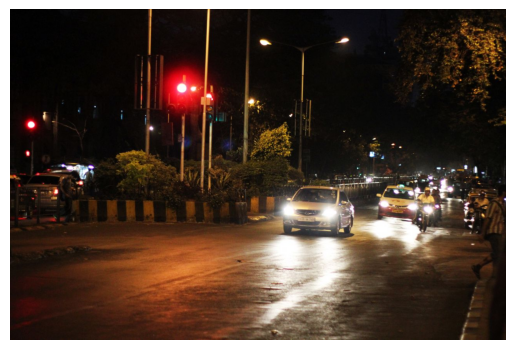

In [10]:
import matplotlib.image as mpimg
image = mpimg.imread('/kaggle/input/imagre/mumbai-night-traffic_preview_19e2.jpg')
plt.imshow(image)
plt.axis('off')
plt.show()

In [11]:
from tensorflow.keras.models import load_model

In [ ]:
filename1 = '/kaggle/working/'
d_model_A.save(filename1)

In [ ]:
g_model_AtoB = define_generator(image_shape)

g_model_BtoA = define_generator(image_shape)

d_model_A = define_discriminator(image_shape)

d_model_B = define_discriminator(image_shape)

c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)

c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

In [16]:
image_shape = dataset[0].shape[1:]

In [17]:
c_model_AtoB = define_composite_model(model_AtoB, d_model_B, model_BtoA, image_shape)

c_model_BtoA = define_composite_model(model_BtoA, d_model_A, model_AtoB, image_shape)

In [32]:
model_json = d_model_A.to_json()
with open("/kaggle/working/d_model_A.json", "w") as json_file:
    json_file.write(model_json)

# Save weights to HDF5
d_model_A.save_weights("/kaggle/working/d_model_A_weights.weights.h5")

In [12]:
from keras.models import model_from_json

# Load JSON and create model
with open('/kaggle/input/output5/d_model_A.json', 'r') as json_file:
    model_json = json_file.read()
d_model_A = model_from_json(model_json, custom_objects={'InstanceNormalization': InstanceNormalization})

# Load weights into the new model
d_model_A.load_weights('/kaggle/input/output5/d_model_A_weights.weights.h5')

In [31]:
model_json = d_model_B.to_json()
with open("/kaggle/working/d_model_B.json", "w") as json_file:
    json_file.write(model_json)

# Save weights to HDF5
d_model_B.save_weights("/kaggle/working/d_model_B_weights.weights.h5")

In [13]:
from keras.models import model_from_json

# Load JSON and create model
with open('/kaggle/input/output5/d_model_B.json', 'r') as json_file:
    model_json = json_file.read()
d_model_B = model_from_json(model_json, custom_objects={'InstanceNormalization': InstanceNormalization})

# Load weights into the new model
d_model_B.load_weights('/kaggle/input/output5/d_model_B_weights.weights.h5')

In [61]:
model_json = c_model_AtoB.to_json()
with open("/kaggle/working/c_model_AtoB.json", "w") as json_file:
    json_file.write(model_json)

# Save weights to HDF5
c_model_AtoB.save_weights("/kaggle/working/c_model_AtoB_weights.weights.h5")

In [62]:
model_json = c_model_BtoA.to_json()
with open("/kaggle/working/c_model_BtoA.json", "w") as json_file:
    json_file.write(model_json)

# Save weights to HDF5
c_model_BtoA.save_weights("/kaggle/working/c_model_BtoA_weights.weights.h5")

In [30]:
model_json = model_AtoB.to_json()
with open("/kaggle/working/model_AtoB.json", "w") as json_file:
    json_file.write(model_json)

# Save weights to HDF5
model_AtoB.save_weights("/kaggle/working/model_AtoB_weights.weights.h5")

In [14]:
from keras.models import model_from_json

# Load JSON and create model
with open('/kaggle/input/output5/model_AtoB.json', 'r') as json_file:
    model_json = json_file.read()
model_AtoB = model_from_json(model_json, custom_objects={'InstanceNormalization': InstanceNormalization})

# Load weights into the new model
model_AtoB.load_weights('/kaggle/input/output5/model_AtoB_weights.weights.h5')

In [29]:
model_json = model_BtoA.to_json()
with open("/kaggle/working/model_BtoA.json", "w") as json_file:
    json_file.write(model_json)

# Save weights to HDF5
model_BtoA.save_weights("/kaggle/working/model_BtoA_weights.weights.h5")

In [15]:
from keras.models import model_from_json

# Load JSON and create model
with open('/kaggle/input/output5/model_BtoA.json', 'r') as json_file:
    model_json = json_file.read()
model_BtoA = model_from_json(model_json, custom_objects={'InstanceNormalization': InstanceNormalization})

# Load weights into the new model
model_BtoA.load_weights('/kaggle/input/output5/model_BtoA_weights.weights.h5')

In [32]:

test_image = img_to_array(image)
test_image_input = np.array([test_image])  
test_image_input = (test_image_input - 127.5) / 127.5

In [33]:
import tensorflow as tf

In [34]:
test_image_input_resized = tf.image.resize(test_image_input, (256, 256))

In [22]:
test_image_input.shape

(1, 853, 1280, 3)

In [40]:
import tensorflow as tf

day_generated = model_AtoB.predict(test_image_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [41]:
night_reconstructed = model_BtoA.predict(day_generated)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


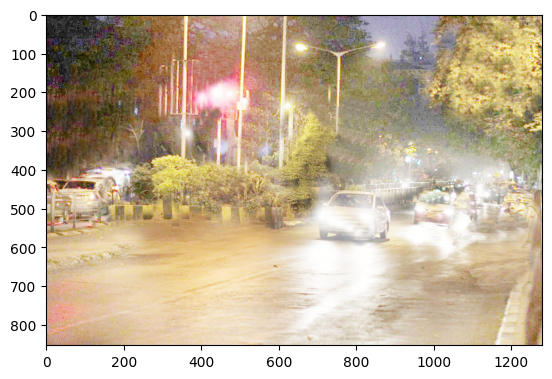

In [49]:
plt.imshow(day_generated[0])

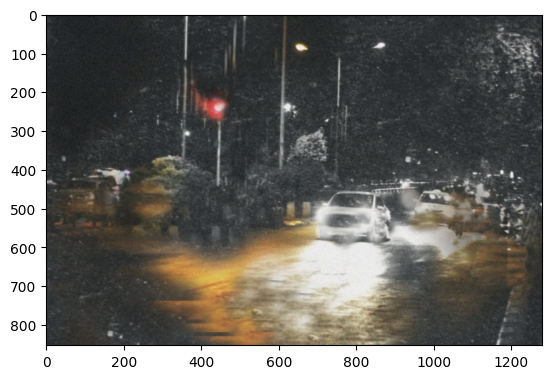

In [53]:
plt.imshow(night_reconstructed[0])